# Алгоритмы кластеризации

Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)


## Реализация алгоритма

Необходимо выбрать и реализовать самостоятельно один из следующих алгоритмов кластеризации:
* Агломеративная иерархическая кластеризация с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)
* DBSCAN. (параметры - epsilon, min_pts)
* OPTICS(\*). (параметры - epsilon, min_pts)
* Gaussian Mixture Model(\*\*) с использованием maximum a-posteriori для выбора кластера (параметр - k)

(\*) - алгоритм не был разобран на занятии. Выбирайте этот пункт только если уверенно умеете программировать и хотите разобраться с более сложной идеей, чем DBSCAN  
(\*\*) - алгоритм не был разобран на занятии, задание повышенной сложности. Выбирайте этот пункт только если хотите разобраться со сложным математическим обоснованием и точно уверены, что сможете запрограммировать и отладить.

## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [2]:
a="""python
function dbscan(X, eps, min_pts):
    initialize NV = X # not visited objects
    for x in NV:
        remove(NV, x) # mark as visited
        nbr = neighbours(x, eps) # set of neighbours
        if nbr.size < min_pts:
            mark_as_noise(x)
        else:
            C = new_cluster()
            expand_cluster(x, nbr, C, eps, min_pts, NV)
            yield C

function expand_cluster(x, nbr, C, eps, min_pts, NV):
    add(x, C)
    for x1 in nbr:
        if x1 in NV: # object not visited
            remove(NV, x1) # mark as visited
            nbr1 = neighbours(x1, eps)
            if nbr1.size >= min_pts:
                # join sets of neighbours
                merge(nbr, nbr_1)
        if x1 not in any cluster:
            add(x1, C)
"""

In [3]:
from sklearn.base import BaseEstimator, ClusterMixin
import random
    

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, min_pts, eps):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.min_pts = min_pts
        self.eps = eps
        self.cluster_num = 5
        self.clusters = []
        
        return
    
    
    def neighbours(self, features_vect):
        nbr = []
        for features in self.NV:
            # calculate distance without mark column
            dist = ss.distance.euclidean(features[:-1], features_vect[:-1])
            if dist < self.eps:
                nbr.append(features)
                
        return nbr
    
    
    def remove_x(self, x):
        x[-1] = 0 # set as visited


    def mark_as_noise(self, x):
        x[-1] = -1 # set as noise

        
    def mark_as_core(self, x, C):
        x[-1] = self.cluster_num # set as core
        
        C.append(x[:-1])
        

    def is_not_visited(self,x):
        if x[-1] == -1:
            return True
        else:
            return False
        

    def expand_cluster(self, x, nbr, C):
        self.mark_as_core(x, C)
        for x1 in nbr:
            if self.is_not_visited(x1): # object not visited
                self.remove_x(x1) # mark as visited
                nbr1 = self.neighbours(x1)
                if len(nbr1) >= self.min_pts:
                    # join sets of neighbours
                    nbr.extend(nbr1)
            if x1[-1] != 3:
                self.mark_as_core(x1, C)
            
            
    def dbscan(self):
        for x in self.NV:
            if self.is_not_visited(x):
                self.remove_x(x)
                nbr = self.neighbours(x)
                if len(nbr) >= self.min_pts:
                    C = []
                    self.cluster_num += 1
                    self.expand_cluster(x, nbr, C)
                    self.clusters.append(C)  
    
    
    def fit(self, X, y=None):
        """
        Use data matrix x to compute model parameters
        """
        #self.labels = -np.zeros(len(X))
        # add zeros column for marking
        self.NV = np.c_[X , -np.ones(len(X)) ]
        self.dbscan()
        self.labels = self.NV[:,-1]
        self.x_len = len(X)
        return self
    
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        return self.labels
    
    def fit_predict(self, x, y=None):
        self.fit(x)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

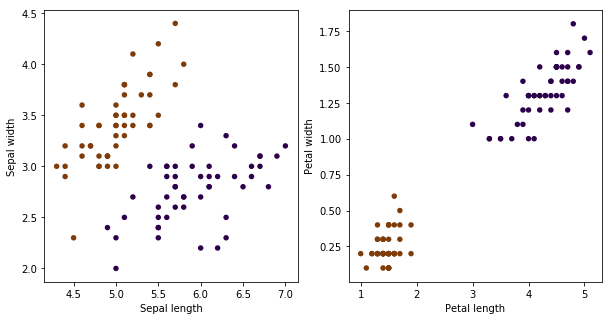

In [4]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

# Сделаем проверку методом из sklearn

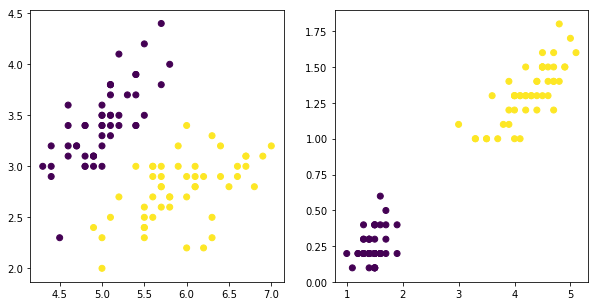

In [5]:
from sklearn.cluster import DBSCAN
def dbscan_demo(X, eps=1, min_pts=1):
    dbscan = DBSCAN(eps=eps, min_samples=min_pts).fit(X)
    labels = dbscan.labels_
    #print(labels)
    pl.figure(figsize=(10, 5))
    pl.subplot(1, 2, 1)
    pl.scatter(X[:, 0], X[:, 1], c=labels)

    pl.subplot(1, 2, 2)
    pl.scatter(X[:, 2], X[:, 3], c=labels)
    
    
dbscan_demo(x_iris)


# Проверим собственный метод

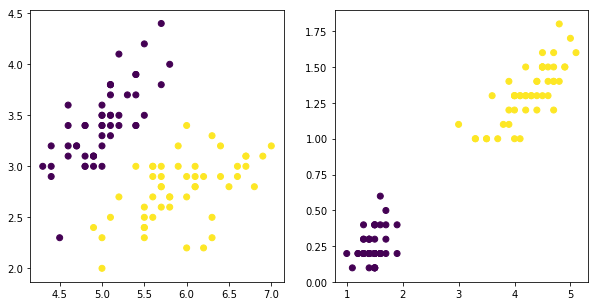

In [6]:
dbscan = Clustering(min_pts=1, eps=1).fit(x_iris)
pred_iris = dbscan.predict(x_iris)
#print(labels)
pl.figure(figsize=(10, 5))
pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=pred_iris)

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=pred_iris)

In [8]:
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 1.00


Подобрать параметры модели с использованием эвристик и критериев качества. 

Критерий локтя:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров, а так же при необходимости изменить этот код (для DBSCAN). На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров. Возможно, необходимо построить такую визуализацию несколько раз.

In [ ]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering()
    y = cls.fit_predict(x)
    criteria[i] = quality(x, y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать с помощью реализованного алгоритма данные, используемые для демонстраций на предыдущих занятиях. Предлагается сделать сравнение с реализацией из sklearn.

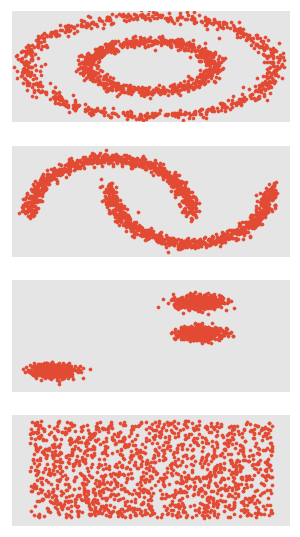

In [4]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

plt.figure(figsize=(2 + 3, 9.5))

data = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # plot
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

plt.show()

In [ ]:
k = 5
cls = Clustering()
y = cls.fit_predict(x)